In [1]:
% matplotlib inline
from pymongo import MongoClient
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import networkx as nx
import nltk
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory
from nltk.tokenize import RegexpTokenizer  
from stop_words import get_stop_words  
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from gensim import corpora, models  
import gensim  


C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
mongo_username = 'Campione'
mongo_password = 'veTRxJL29lpKWwPn'
mongo_url = 'mongodb://%s:%s@cluster0-shard-00-01-i6gcp.mongodb.net:27017/admin' % (
            mongo_username, mongo_password)
client = MongoClient(mongo_url,ssl=True,replicaSet='Cluster0-shard-0',authSource='admin')
info = client.server_info()  # Forces a call.
# print(info)
print(client.database_names())

['gitdb', 'gitdbPro', 'guidebook', 'test', 'admin', 'local']


In [3]:
db = client.gitdbPro
repos = db.repos
descriptions = repos.distinct('description')
df = pd.DataFrame(descriptions)
df.head()

,0
0,How to be low-level programmer
1,Import OpenStreetMap data into Unreal Engine 4
2,react-native template to target multiple platf...
3,Connect your App to Multiple Messaging Channel...
4,Proto Actor - Ultra fast distributed actors fo...


In [4]:
df[0]

0                           How to be low-level programmer
1           Import OpenStreetMap data into Unreal Engine 4
2        react-native template to target multiple platf...
3        Connect your App to Multiple Messaging Channel...
4        Proto Actor - Ultra fast distributed actors fo...
5                用rxjava简单封装了指纹识别，并实现对生命周期的自动绑定，顺便撸了一个指纹控件
6                                   pagehelper-spring-boot
7            📅 A date picker components for ionic2 ／ionic3
8        Track prices on Amazon and receive email alert...
9        Advanced web based trading client for the Stel...
10                                  Join our slack channel
11       An Elm-based prototype to help designers build...
12       Can neural networks transliterate Romaji into ...
13                              A repo with small projects
14               Go - CQRS / Event Sourcing made easy - Go
15                                RNN Tutorial for Artists
16       A macOS app to convert JSON objects into Swift.

In [5]:
DetectorFactory.seed = 0

In [6]:
cn_text_list = []
en_text_list = []
for item in df[0]:
    try:
        if detect(str(item)) == 'zh-cn':
            cn_text_list.append(item)
        else:
            en_text_list.append(item)
    except Exception as e:
        print(str(e))

No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.
No features in text.


In [7]:
len(cn_text_list)

697

In [8]:
len(en_text_list)

11143

In [9]:
df_cn = pd.DataFrame({'text':cn_text_list})
print(df_cn.head())
df_cn.to_csv('cn_text')

                                                text
0          用rxjava简单封装了指纹识别，并实现对生命周期的自动绑定，顺便撸了一个指纹控件
1           每周一篇，内容精简，不咸不淡，期盼探讨。微信公众号：芋道源码【纯源码分享公众号】
2                                  iOS即时通讯，从入门到“放弃”？
3  『假装看天气』─── 天气预报 & 公交查询 & 资讯阅读 & 妹纸福利 的 Android...
4                                         微信小程序－日历 📅


In [10]:
df_en = pd.DataFrame({'text':en_text_list})
print(df_en.head())
df_en.to_csv('en_text')

                                                text
0                     How to be low-level programmer
1     Import OpenStreetMap data into Unreal Engine 4
2  react-native template to target multiple platf...
3  Connect your App to Multiple Messaging Channel...
4  Proto Actor - Ultra fast distributed actors fo...


In [11]:
# GENERATE LDA Model
import re

# list for tokenized documents in loop  
texts = []
tokenizer = RegexpTokenizer(r'\w+')
# create English stop words list
en_stop = get_stop_words('en')
# Create p_stemmer of class PorterStemmer
stemmer = SnowballStemmer("english")

# loop through document list  
for i in en_text_list:
    if i is not None:
        raw = i.lower()
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw)
        
        # remove stop words from tokens  
        stopped_tokens = [i for i in tokens if not i in en_stop]
        
        # remove all numbers
        without_numbers = [re.sub(r'\d+', '', i) for i in stopped_tokens]
        
        # stem tokens
        stemmed_tokens = [stemmer.stem(i) for i in without_numbers]
        
        # add tokens to list
        texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
      
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)

In [12]:
for topic in ldamodel.print_topics(num_words=5, num_topics=20):
    print(topic)

(0, '0.026*"perform" + 0.024*"node" + 0.022*"high" + 0.021*"js" + 0.018*"use"')
(1, '0.031*"easi" + 0.026*"way" + 0.022*"use" + 0.017*"make" + 0.014*"cryptocurr"')
(2, '0.021*"kubernet" + 0.017*"state" + 0.017*"golang" + 0.016*"docker" + 0.015*"manag"')
(3, '0.030*"visual" + 0.022*"load" + 0.017*"tool" + 0.017*"vulner" + 0.014*"inform"')
(4, '0.046*"system" + 0.028*"css" + 0.022*"cli" + 0.018*"file" + 0.017*"json"')
(5, '0.044*"https" + 0.041*"com" + 0.040*"github" + 0.023*"http" + 0.020*"request"')
(6, '0.095*"react" + 0.066*"app" + 0.058*"android" + 0.042*"nativ" + 0.029*"compon"')
(7, '0.056*"list" + 0.033*"awesom" + 0.029*"resourc" + 0.027*"curat" + 0.026*"collect"')
(8, '0.030*"swift" + 0.029*"line" + 0.027*"command" + 0.026*"extens" + 0.023*"c"')
(9, '0.062*"vue" + 0.053*"js" + 0.046*"compon" + 0.032*"render" + 0.029*"anim"')
(10, '0.053*"network" + 0.053*"sourc" + 0.043*"open" + 0.021*"game" + 0.021*"neural"')
(11, '0.020*"" + 0.018*"io" + 0.015*"swift" + 0.006*"encrypt" + 0.006

In [12]:
from gensim.models.wrappers import LdaMallet

mallet_path = r"/mallet-2.0.8/bin/mallet"
model = LdaMallet(mallet_path, corpus, num_topics=10, id2word=dictionary)
print(model[corpus])

CalledProcessError: Command '/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\WENXUA~1\AppData\Local\Temp\2aff1e_corpus.txt --output C:\Users\WENXUA~1\AppData\Local\Temp\2aff1e_corpus.mallet' returned non-zero exit status 1.

In [37]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
18     7.387607        1       1  0.145648  0.066687
1      7.253919        1       2  0.159180  0.099013
11     7.100750        1       3 -0.201542  0.081528
5      6.692833        1       4  0.134724  0.064034
9      6.119545        1       5  0.165886  0.026005
8      5.604881        1       6  0.104163 -0.049512
12     5.574208        1       7  0.066633 -0.109926
19     5.158065        1       8  0.061571  0.115921
13     4.932799        1       9 -0.014027 -0.191317
16     4.917088        1      10 -0.013791 -0.245968
3      4.754025        1      11  0.049887 -0.025431
15     4.672791        1      12 -0.163693  0.141623
10     4.599256        1      13  0.023820  0.085545
4      4.508649        1      14 -0.019291  0.004099
14     4.478775        1      15 -0.008019 -0.103478
2      4.062645        1      16  0.028089  0.027948
0      3.199340        1      17 -0.117996 -0.002155
17     3.185379        1      18 -0.116161  0.004298
6      2.922318        1      19 -0.145399  0.007533
7      2.875127        1      20 -0.139681  0.003553, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
3     Default  1312.000000              1312.000000  30.0000  30.0000
114   Default   431.000000       learn   431.000000  29.0000  29.0000
100   Default   434.000000   implement   434.000000  28.0000  28.0000
16    Default   513.000000       react   513.000000  27.0000  27.0000
143   Default   438.000000     android   438.000000  26.0000  26.0000
176   Default   302.000000          js   302.000000  25.0000  25.0000
234   Default   294.000000      python   294.000000  24.0000  24.0000
4     Default   255.000000        data   255.000000  23.0000  23.0000
178   Default   289.000000         vue   289.000000  22.0000  22.0000
80    Default   246.000000       sourc   246.000000  21.0000  21.0000
39    Default   319.000000      compon   319.000000  20.0000  20.0000
484   Default   230.000000        list   230.000000  19.0000  19.0000
113   Default   203.000000        deep   203.000000  18.0000  18.0000
14    Default   229.000000       nativ   229.000000  17.0000  17.0000
53    Default   279.000000     network   279.000000  16.0000  16.0000
1263  Default   191.000000     pytorch   191.000000  15.0000  15.0000
225   Default   298.000000         api   298.000000  14.0000  14.0000
391   Default   409.000000        tool   409.000000  13.0000  13.0000
91    Default   269.000000       swift   269.000000  12.0000  12.0000
24    Default   201.000000        open   201.000000  11.0000  11.0000
28    Default   208.000000           c   208.000000  10.0000  10.0000
115   Default   164.000000      machin   164.000000   9.0000   9.0000
217   Default   190.000000      server   190.000000   8.0000   8.0000
20    Default   439.000000         app   439.000000   7.0000   7.0000
167   Default   261.000000     generat   261.000000   6.0000   6.0000
152   Default   256.000000        imag   256.000000   5.0000   5.0000
187   Default   168.000000        anim   168.000000   4.0000   4.0000
15    Default   154.000000    platform   154.000000   3.0000   3.0000
627   Default   160.000000  tensorflow   160.000000   2.0000   2.0000
466   Default   154.000000        view   154.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
381   Topic20    19.792976    transpar    20.620417   3.5081  -4.8044
955   Topic20    18.457299   microsoft    19.284740   3.5052  -4.8743
2358  Topic20    18.199537      storag    19.026978   3.5046  -4.8884
232   Topic20    18.112787        susi    18.940228   3.5044  -4.8932
676   Topic20    17.425768       agent    18.253209   3.5027  -4.9318
556   Topic20    17.162165          es    17.989606   3.5020  -4.9471
1080  Topic20    15.679850         dev    16.507291   3.4976 

In [49]:
# SKLEARN LEARN LDA
from __future__ import print_function
from time import time
from random import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 7000
n_features = 100
n_components = 5
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [50]:
# shuffle the data
en_shuffle = en_text_list
shuffle(en_shuffle)
print(en_shuffle)
len(en_shuffle)

[' 基于vue2.0 +vuex+ element-ui后台管理系统 ', 'Go library that provides fuzzy string matching optimized for filenames and code symbols in the style of Sublime Text, VSCode, IntelliJ IDEA et al.', ':boar: :bear: Deep Learning based Python Library for Stock Market Prediction and Modelling', 'Geohashes in proximity', 'GUI Diff Tool for Excel', 'Car Backdoor Maker - by @UnaPibaGeek & @holesec', 'A framework for running WeChat applet', 'How to get free wifi.', ':bulb: A community-curated list of awesome resources to help you grow as a CTO', 'pagehelper-spring-boot', '代理IP 采集程序', "Is headless chrome currently detectable? Let's pit the detections and detection evasions against eachother.", 'A differentiable LCP physics engine in PyTorch.', '一个支持匹配点击的 label . a label, Supports attributes text matching clicks.', 'A curated list of awesome Security Hardening techniques for Windows.', ':rocket: One command to generate REST APIs for any MySql Database.', 'Create the next immutable state by mutating the c

11143

In [51]:
# Get data sample
en_samples = en_shuffle[:n_samples]
len(en_samples)

7000

In [52]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(en_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
dtm_tf = tf_vectorizer.fit_transform(en_samples)
# tfid_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(en_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.102s.
Extracting tf features for LDA...
done in 0.185s.


In [53]:
print(dtm_tf.shape)
print(dtm_tf)
print(dtm_tfidf.shape)
print(dtm_tfidf)

(7000, 100)
  (1, 86)	1
  (1, 82)	1
  (1, 13)	1
  (1, 48)	1
  (2, 72)	1
  (2, 8)	1
  (2, 47)	1
  (2, 24)	1
  (2, 48)	1
  (4, 88)	1
  (6, 32)	1
  (8, 77)	1
  (8, 7)	1
  (8, 53)	1
  (8, 21)	1
  (12, 73)	1
  (13, 86)	1
  (14, 98)	1
  (14, 78)	1
  (14, 7)	1
  (14, 53)	1
  (14, 21)	1
  (15, 16)	1
  (16, 19)	1
  (17, 23)	1
  :	:
  (6989, 65)	1
  (6989, 35)	1
  (6989, 32)	1
  (6989, 8)	1
  (6990, 81)	2
  (6990, 64)	3
  (6990, 48)	1
  (6991, 61)	1
  (6991, 13)	1
  (6992, 10)	1
  (6992, 99)	1
  (6993, 19)	1
  (6994, 39)	1
  (6994, 85)	1
  (6996, 77)	1
  (6997, 86)	1
  (6997, 48)	1
  (6998, 91)	1
  (6998, 8)	1
  (6999, 65)	1
  (6999, 5)	1
  (6999, 97)	1
  (6999, 80)	1
  (6999, 29)	2
  (6999, 32)	1
(7000, 100)
  (1, 48)	0.390427028913
  (1, 13)	0.428685162623
  (1, 82)	0.586688360848
  (1, 86)	0.565325157485
  (2, 48)	0.388097269655
  (2, 24)	0.495245539035
  (2, 47)	0.4507092832
  (2, 8)	0.430514391121
  (2, 72)	0.464360707239
  (4, 88)	1.0
  (6, 32)	1.0
  (8, 21)	0.514487344788
  (8, 53)	0.4505

In [54]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(dtm_tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=7000 and n_features=100...
done in 0.396s.

Topics in NMF model (Frobenius norm):
Topic #0: library javascript python lightweight data fast text ui programming swift ios performance written support user client create platform line image
Topic #1: react native app component components ios apps create js built ui web like build com design use css development api
Topic #2: code source https 2017 open learning github plugin networks com tool project python server model javascript support language line neural
Topic #3: android app ios view kotlin easy project design plugin custom java application use using client simple ui native development text
Topic #4: simple based framework using learning implementation js vue python deep web api tool pytorch data tensorflow machine use node project

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=7000 and n_features=100...
done in 0.2

In [55]:
# print(lda.components_)
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pyLDAvis.sklearn.prepare(lda, dtm_tfidf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      23.203032        1       1  0.243412  0.298014
2      21.515247        1       2 -0.029542 -0.357297
3      19.387729        1       3 -0.383267 -0.127075
4      18.473661        1       4 -0.213691  0.365994
1      17.420332        1       5  0.383088 -0.179636, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
74    Default  238.000000           react  238.000000  30.0000  30.0000
8     Default  182.000000           based  182.000000  29.0000  29.0000
47    Default  166.000000        learning  166.000000  28.0000  28.0000
1     Default  190.000000         android  190.000000  27.0000  27.0000
80    Default  170.000000          simple  170.000000  26.0000  26.0000
39    Default  139.000000  implementation  139.000000  25.0000  25.0000
88    Default  134.000000            tool  134.000000  24.0000  24.0000
13    Default  162.000000            code  162.000000  23.0000  23.0000
32    Default  141.000000       framework  141.000000  22.0000  22.0000
48    Default  227.000000         library  227.000000  21.0000  21.0000
97    Default  124.000000             web  124.000000  20.0000  20.0000
58    Default  111.000000          native  111.000000  19.0000  19.0000
23    Default  113.000000            data  113.000000  18.0000  18.0000
43    Default  126.000000              js  126.000000  17.0000  17.0000
2     Default  115.000000             api  115.000000  16.0000  16.0000
53    Default  102.000000            list  102.000000  15.0000  15.0000
72    Default  112.000000          python  112.000000  14.0000  14.0000
24    Default   98.000000            deep   98.000000  13.0000  13.0000
95    Default  110.000000             vue  110.000000  12.0000  12.0000
40    Default  103.000000             ios  103.000000  11.0000  11.0000
73    Default   84.000000         pytorch   84.000000  10.0000  10.0000
90    Default   77.000000              ui   77.000000   9.0000   9.0000
93    Default  172.000000           using  172.000000   8.0000   8.0000
81    Default   91.000000          source   91.000000   7.0000   7.0000
84    Default   79.000000           swift   79.000000   6.0000   6.0000
85    Default   78.000000      tensorflow   78.000000   5.0000   5.0000
67    Default   72.000000        platform   72.000000   4.0000   4.0000
11    Default   70.000000           built   70.000000   3.0000   3.0000
3     Default  132.000000             app  132.000000   2.0000   2.0000
37    Default   74.000000           https   74.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
54     Topic5   55.413688         machine   55.899325   1.7388  -3.1680
35     Topic5   52.490034            high   52.978936   1.7383  -3.2222
56     Topic5   50.222498      management   50.712572   1.7378  -3.2664
65     Topic5   50.148591     performance   50.640090   1.7378  -3.2679
26     Topic5   49.212745     development   49.700850   1.7377  -3.2867
67     Topic5   71.616901        platform   72.329829   1.7376  -2.9115
55     Topic5   42.809125            make   43.297323   1.7362  -3.4261
76     Topic5   40.658013      repository   41.142716   1.7357  -3.4777
9      Topic5   45.506735         browser   46.139669   1.7337  -3.3650
18     Topic5   57.672570      components   76.421203   1.4661  -3.1281
61     Topic5   38.285794        networks   58.088157   1.3306  -3.5378
93     Topic5  100.008433           using  172.003201   1.2053  -2.5776
27     Topic5    0.747021            easy   68.670322  -2.7734  -7.4745
42     Topic5    0.335148      javascript   68.536433  -3.5730  -8.2760
59     Topic5    0.152014             net   31.509790  -3.5865  -9.0666
75     Topic5    0.186558            real   40.133926  -3.6237  -8.8619
31     Topic5    0.145079           files   32.9786

In [56]:
fp1 = open('./results/docprobs_35.txt')
str_prop_arr = []
for line in fp1.readlines():
    str_prop_arr.append(line.replace("\n",""))
fp1.close()

fp2 = open('./results/sum.txt')
str_count_arr = []
for line in fp2.readlines():
    str_count_arr.append(line.replace("\n",""))
fp2.close()

prop_arr = list(map(float, str_prop_arr))
count_arr = list(map(int, str_count_arr))

log_likelihood = 0
sum = 0

for val in prop_arr:
    log_likelihood += val
    
for count in count_arr:
    sum += count

print(sum)
print(log_likelihood)
perplexity = 2**(-(log_likelihood/sum))
print(perplexity)

77237
-570823.9774006146
167.794412854037


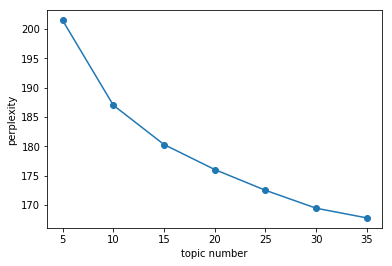

In [57]:
topics_num = [5,10,15,20,25,30,35]
perplexity_array = [201.51309228186344,187.02964688607923,180.31479669874173,176.04686564166764,172.5083842791524,169.44647660180442,167.794412854037]

plt.plot(topics_num, perplexity_array, marker='o')
plt.xlabel('topic number')
plt.ylabel('perplexity')
plt.show()